In [1]:
import h5py 
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 
from matplotlib.colors import LogNorm 
import imageio 
import seaborn as sns
import time 
import tqdm 

In [2]:
########## ########## ########## 
########## Opening data 
########## ########## ########## 
basedir = "/scratch/fhgfs/xray/p002330/" 
datadir = basedir + "/scan/" 
    
# Diffraction data and posy and posz 
data = datadir + "r0129.h5" 
agipd_data = h5py.File(data, 'r') 

diff_pats = agipd_data["AGIPD/data"] 
N = diff_pats.shape[0] 
N_pulses = diff_pats.shape[1]
posx = np.array(agipd_data["/DA03/ACTX"]) 
posy = np.array(agipd_data["/DA03/ACTY"]) 
posz = np.array(agipd_data["/DA03/ACTZ"]) 

px = np.array(agipd_data["/DA03/TARX"])
py = np.array(agipd_data["/DA03/TARY"])
pz = np.array(agipd_data["/DA03/TARZ"])

# Masking data 
mask = datadir + "r0129_sin.h5" 
mask_data = h5py.File(mask, 'r') 

pat_mask = np.array(mask_data["AGIPD/mask"]) 
########## ########## ########## 
########## ########## ########## 
########## ########## ########## 

In [3]:
# Printing out posx, posy, and posz 
print(np.finfo('float32'))
f32eps = np.finfo('float32').eps
print("float32 machine epsilon: %s" % (f32eps))
print("diffraction pattern shape:", diff_pats.shape) 
print("mask shape:", pat_mask.shape) 
print("posx shape:", posx.shape) 
print("posy shape:", posy.shape) 
print("posz shape:", posz.shape) 
print("px shape:", py.shape) 
print("py shape:", py.shape) 
print("pz shape:", pz.shape) 
print("data type of posx:", posx.dtype)
print("data type of posy:", posy.dtype)
print("data type of posz:", posz.dtype)
print("data type of px:", px.dtype)
print("data type of py:", py.dtype)
print("data type of pz:", pz.dtype)
print() 

print("posx:\n", posx)
printX = False 
if printX:
    with np.printoptions(threshold = np.inf): 
        print("posx:\n", posx)
        print() 

print("posy:\n", posy) 
printY = False   
if printY:
    with np.printoptions(threshold = np.inf):
        print("posy:\n", posy) 
        print() 
     
print("posz:\n", posz)
printZ = False  
if printZ:
    with np.printoptions(threshold = np.inf):
        print("posz:\n", posz) 
        print() 

print("px:\n", px) 
pX = False    
if pX: 
    with np.printoptions(threshold = np.inf):
        print("px:\n", px) 
        print()         
        
print("py:\n", py) 
pY = False 
if pY: 
    with np.printoptions(threshold = np.inf): 
        print("py:\n", py) 
        print() 
     
print("pz:\n", pz) 
pZ = False 
if pZ: 
    with np.printoptions(threshold = np.inf):
        print("pz:\n", pz) 
        print() 

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

float32 machine epsilon: 1.1920929e-07
diffraction pattern shape: (12925, 220, 210, 210)
mask shape: (210, 210)
posx shape: (12925,)
posy shape: (12925,)
posz shape: (12925,)
px shape: (12925,)
py shape: (12925,)
pz shape: (12925,)
data type of posx: float32
data type of posy: float32
data type of posz: float32
data type of px: float32
data type of py: float32
data type of pz: float32

posx:
 [2.7435074 2.7435074 2.7435074 ... 2.7435951 2.7435951 2.7435951]
posy:
 [48.008595 48.008595 48.008595 ... 52.499496 52.499496 52.499496]
posz:
 [0.25023937 0.25023937 0.25023937 ...

In [4]:
# Print each pair of py and pz
printPairs = False
if printPairs:
    begin = 0 
    end = N
    for i in range(begin, end): 
        print("index %s: (%s, %s)" % (i, py[i], pz[i]))

In [5]:
################# Same analysis using TARY and TARZ as target positions 
n_unq, n_same = 0, 0 

for i in range(N): 
    if i == (N - 1):
        n_unq += 1 
        break 
    else: 
        if (np.abs(py[i+1] - py[i]) < f32eps) and (np.abs(pz[i+1] - pz[i]) < f32eps): 
            n_same += 1 
        else: 
            n_unq += 1 
            
print("\nNumber of unique scan positions: %s." % (n_unq)) 
print("Number of the same scan positions: %s." % (n_same)) 

same_pos = [] 
unq_pos = [[] for _ in range(n_unq)] 
j = 0 

for i in range(N): 
    if i == (N - 1): 
        same_pos.append(i) 
        unq_pos[j] = same_pos[:] 
        same_pos.clear() 
    else: 
        if (np.abs(py[i+1] - py[i]) < f32eps) and (np.abs(pz[i+1] - pz[i]) < f32eps):
            same_pos.append(i) 
        else: 
            same_pos.append(i) 
            unq_pos[j] = same_pos[:]
            same_pos.clear() 
            j += 1 
        
unq_pos = np.array(unq_pos, dtype = type(unq_pos)) 


Number of unique scan positions: 811.
Number of the same scan positions: 12114.


In [6]:
# Function that takes in a list of lists of unique scan positions and outputs the correlation matrix between pulse trains
# and the average correlation for all unique positions... 
# Firstly, return the average correlation value for each unique position...
# Finally, return the correlation matrix for each unique position...
def calculate_correlation(unique_positions, diffraction_patterns, mask, normalize = False, corrType = "pearson"): 
    if normalize:
        print("Normalizing pulse trains!") 
    else: 
        print("Not normalizing pulse trains!") 
    
    if corrType == "pearson": 
        print("Correlation type: Pearson!")
    elif corrType == "spearman": 
        print("Correlation type: Spearman!")
    else: 
        print("Other correlations not supported!")
    
    diff_pats = diffraction_patterns 
    num_unique = len(unique_positions) 
    
    # Pre-allocating of correlation statistic arrays 
    av_corr, min_corr, max_corr, std_corr = np.zeros(shape = (num_unique)), np.zeros(shape = (num_unique)), np.zeros(shape = (num_unique)), np.zeros(shape = (num_unique))
    med_corr = np.zeros(shape = (num_unique,)) 
    
    per_train_total = np.zeros(shape = (num_unique,))

    flat_mask = mask.reshape(210 * 210) 
    good_pix = (flat_mask == True) 
    p_bar = tqdm.trange(num_unique) 

    for p in p_bar: 
        # Selecting diffraction patterns corresponding to unique positions 
        selected_diffs = diff_pats[unique_positions[p] , :,:,:] 
        n_trains = len(unique_positions[p]) 
        
        # Integrate all pulses in each pulse train
        coh_int = np.sum(selected_diffs, axis = 1).reshape(-1, 210*210)
        coh_good = coh_int[:, good_pix] 
        
        # Initializing good trains array 
        good_trains = coh_good 

        # Delete all pulse trains that are a constant zero vector 
        for t in range(n_trains): 
            set_train = set(coh_good[t, :])
            if (0 in set_train and len(set_train) == 1): 
                good_trains = np.delete(coh_good, t, 0)   
        n_good_trains = good_trains.shape[0] 
        
        # Integrate all pulse trains in each position to get per-train intensity
        good_train_int = np.sum(good_trains, axis = 1) 
        per_train_total[p] = np.sum(good_train_int) 
        
        # Normalize each pulse train with its per-train total intensity 
        if normalize: 
            good_trains = np.zeros(shape = (n_good_trains,len(good_pix[good_pix == True])))
            for i in range(n_good_trains): 
                good_trains[i,:] = (good_trains[i,:] / good_train_int[i]) 
        
        # Selecting upper triangular part of correlation matrix 
        upper_triag = np.triu_indices(n_good_trains, k = 1)
        
        # Calculating correlation coefficients 
        corr_co = np.zeros(shape = (n_good_trains,n_good_trains)) 
        for i in range(n_good_trains): 
            pt_i = good_trains[i, :] 
            for j in range(n_good_trains): 
                pt_j = good_trains[j, :] 
                if corrType == "pearson":
                    r_co, p_co = scipy.stats.pearsonr(pt_i, pt_j) 
                elif corrType == "spearman":
                    r_co, p_co = scipy.stats.spearmanr(pt_i, pt_j) 
            corr_co[i, j] = r_co 
        
        # Appending unnormalized and normalized correlation statistics
        corr_upper = corr_co[upper_triag] 
        av_corr[p] = corr_upper.mean() 
        min_corr[p] = corr_upper.min() 
        max_corr[p] =  corr_upper.max()  
        std_corr[p] = corr_upper.std() 
        med_corr[p] = np.median(corr_upper) 

    return av_corr, min_corr, max_corr, std_corr, med_corr, per_train_total

In [7]:
# Selecting an unique position 
sel_pos = 110 
sel = unq_pos[sel_pos]
n_trains = len(sel) 
print("Selected unique position list: %s." % (sel)) 
print("Number of pulse trains for selected unique position: %s." % (n_trains))
sel_diffs = diff_pats[sel, :, :, :] 
print("Selected diffraction patterns shape: (%s, %s, %s, %s)." % (sel_diffs.shape[0],sel_diffs.shape[1],sel_diffs.shape[2],sel_diffs.shape[3]))

# Pulse integration of selected position 
int_pulse = np.sum(sel_diffs, axis = 1) 

# Correlate the 220 pulses at each unique position with each other 
# Do this with/without mask 

plotIntTrains = False 
if plotIntTrains: 
    p_train = 2 
    plt.figure(1, figsize = (5,5)) 
    plt.imshow(int_pulse[p_train,:,:], cmap = 'hot', interpolation = None)#, norm = LogNorm())
    plt.title("Coherently integrated pulse train %s" % (p_train)) 
    plt.colorbar(); 
    
# Flatten the coherent and incoherently integrated diffraction patterns
pulsef = int_pulse.reshape(-1, 210*210) 

# Flatten mask and use flattened mask to choose only good pixels 
flat_mask = pat_mask.reshape(210 * 210) 
good_pix = (flat_mask == True) 
bad_pix = (flat_mask == False) 
print("Number of good pixels: %s." % len(good_pix[good_pix == True]))
print("Number of bad pixels: %s." % len(bad_pix[bad_pix== True])) 

plotGoodBad = False
if plotGoodBad: 
    plt.figure(1, figsize = (5,5))
    plt.imshow(good_pix.reshape(210, 210), cmap = 'jet', interpolation = None)
    plt.title("Good pixels")
    plt.colorbar() 
    plt.figure(2, figsize = (5,5))
    plt.imshow(bad_pix.reshape(210, 210), cmap = 'jet', interpolation = None)
    plt.title("Bad pixels")
    plt.colorbar(); 

pulse_good = pulsef[:, good_pix] 

# Deleting all pulse trains that are constant to zero 
for t in range(n_trains): 
    set_train = set(pulse_good[t, :])
    if (0 in set_train and len(set_train) == 1): 
        good_trains = np.delete(pulse_good, t, 0)   
n_good_trains = good_trains.shape[0] 
print("Number of good pulse trains for selected unique position: %s out of %s." % (n_good_trains,n_trains))

# Integrate all good pixels in a train to get integrated intensity 
# Integrate all pixels first for each position within unique position
good_train_int = np.sum(good_trains, axis = 1)
# Now integrate all pulse trains belonging to each unique position
good_train_all = np.sum(good_train_int)
print("Integrated intensity for each pulse train in unique position: %s." % (good_train_int))
print("Integrated intensity chosen unique position: %s." % (good_train_all)) 
print()

int_gti_mean = np.mean(good_train_int) 
int_gti_min = np.min(good_train_int)
int_gti_max = np.max(good_train_int)
int_gti_std = np.std(good_train_int) 
int_gti_med = np.median(good_train_int) 
print("------------------------------------------------------")
print("Statistics integrated intensity per unique position:")
print("------------------------------------------------------")
print("Average intensity all trains: %s" % (int_gti_mean))
print("Minimum intensity all trains: %s" % (int_gti_min))
print("Maximum intensity all trains: %s" % (int_gti_max))
print("Std intensity all trains: %s" % (int_gti_std))
print("Median intensity all trains: %s" % (int_gti_med))
print("------------------------------------------------------")
print("------------------------------------------------------")

# Correlation between pulse trains at each unique position
co_corr = np.zeros(shape = (n_good_trains,n_good_trains)) 
        
for i in range(n_good_trains): 
    pt_i = good_trains[i, :] 
    for j in range(n_good_trains): 
        pt_j = good_trains[j, :] 
        r_co, p_co = scipy.stats.pearsonr(pt_i, pt_j) 
        co_corr[i, j] = r_co 
        
upper_triag = np.triu_indices(n_good_trains, k = 1) 
corr_upper = co_corr[upper_triag] 

av_co = np.mean(corr_upper) 
min_co = np.min(corr_upper) 
max_co = np.max(corr_upper) 
std_co = np.std(corr_upper) 
med_co = np.median(corr_upper) 

print("------------------------------------------------------")
print("Correlation statistics:")
print("------------------------------------------------------")
print("Average correlation: %s" % (av_co)) 
print("Minimum correlation: %s" % (min_co)) 
print("Maximum correlation: %s" % (max_co)) 
print("Standard deviation correlation: %s" % (std_co)) 
print("Median correlation: %s" % (med_co)) 
print("------------------------------------------------------")
print("------------------------------------------------------")
print()

# Correlation for normalized pulse trains
# Normalize all pulse trains belonging to unique position with total intensity per unique position 

good_train_normed = np.zeros(shape=(n_good_trains,len(good_pix[good_pix == True])))
for i in range(n_good_trains): 
    good_train_normed[i,:] = (good_trains[i,:] / good_train_int[i]) * int_gti_mean
    
print()
    
co_corr_normed = np.zeros(shape = (n_good_trains,n_good_trains)) 

for i in range(n_good_trains): 
    pt_i = good_train_normed[i, :] 
    for j in range(n_good_trains): 
        pt_j = good_train_normed[j, :] 
        r_co, p_co = scipy.stats.pearsonr(pt_i, pt_j) 
        co_corr_normed[i, j] = r_co 
        
upper_triag = np.triu_indices(n_good_trains, k = 1) 
corr_norm_upper = co_corr_normed[upper_triag] 
    
av_co_norm = np.mean(corr_norm_upper) 
min_co_norm = np.min(corr_norm_upper) 
max_co_norm = np.max(corr_norm_upper) 
std_co_norm = np.std(corr_norm_upper) 
med_co_norm = np.median(corr_norm_upper) 

print("------------------------------------------------------")
print("Correlation statistics normalized pulse trains:")
print("------------------------------------------------------")
print("Average correlation: %s" % (av_co_norm)) 
print("Minimum correlation: %s" % (min_co_norm)) 
print("Maximum correlation: %s" % (max_co_norm)) 
print("Standard deviation correlation: %s" % (std_co_norm)) 
print("Median correlation: %s" % (med_co_norm)) 
print("------------------------------------------------------")
print("------------------------------------------------------")

Selected unique position list: [1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230].
Number of pulse trains for selected unique position: 11.
Selected diffraction patterns shape: (11, 220, 210, 210).
Number of good pixels: 16958.
Number of bad pixels: 27142.
Number of good pulse trains for selected unique position: 10 out of 11.
Integrated intensity for each pulse train in unique position: [4040344 3830667 3818233 3994797 3684999 3961969 4027311 3817376 2729765
 3438585].
Integrated intensity chosen unique position: 37344046.

------------------------------------------------------
Statistics integrated intensity per unique position:
------------------------------------------------------
Average intensity all trains: 3734404.6
Minimum intensity all trains: 2729765
Maximum intensity all trains: 4040344
Std intensity all trains: 377016.12859669543
Median intensity all trains: 3824450.0
------------------------------------------------------
-----------------------------------

In [8]:
# Pearson correlations 
av_pear, min_pear, max_pear, std_pear, med_pear, per_train_tot_pear = calculate_correlation(unq_pos, diff_pats, pat_mask, False, "pearson") 

Not normalizing pulse trains!
Correlation type: Pearson!


100%|██████████| 811/811 [08:47<00:00,  1.54it/s]


In [9]:
# Spearman correlations 
av_spear, min_spear, max_spear, std_spear, med_spear, per_train_tot_spear = calculate_correlation(unq_pos, diff_pats, pat_mask, False, "spearman") 

Not normalizing pulse trains!
Correlation type: Spearman!


100%|██████████| 811/811 [18:13<00:00,  1.35s/it]


In [10]:
# Count the number of unique positions with nan values
nans = np.isnan(av_pear) 
num_nans = 0 
for i in range(len(nans)): 
    if nans[i] == True: 
        num_nans += 1 
print("There are %s NaNs." % (num_nans)) 

There are 0 NaNs.


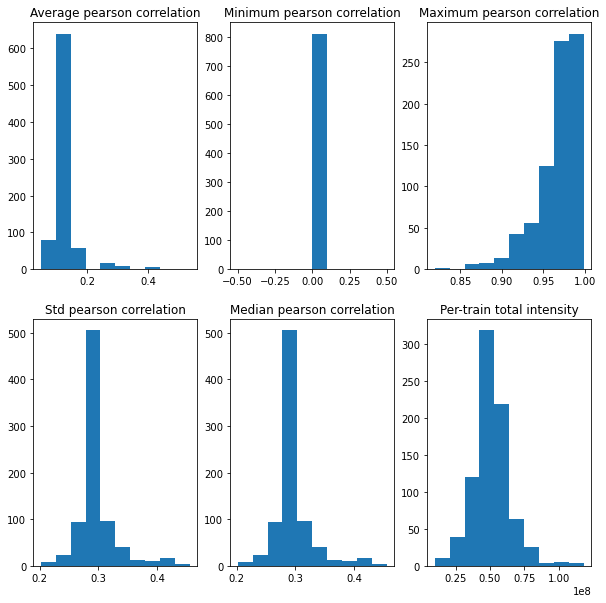

In [11]:
# Pearson correlation statistics 
fig, ax = plt.subplots(2, 3, figsize = (10,10))
ax[0,0].hist(av_pear)
ax[0,0].set_title("Average pearson correlation") 
ax[0,1].hist(min_pear) 
ax[0,1].set_title("Minimum pearson correlation") 
ax[0,2].hist(max_pear) 
ax[0,2].set_title("Maximum pearson correlation") 
ax[1,0].hist(std_pear) 
ax[1,0].set_title("Std pearson correlation") 
ax[1,1].hist(std_pear) 
ax[1,1].set_title("Median pearson correlation") 
ax[1,2].hist(per_train_tot_pear) 
ax[1,2].set_title("Per-train total intensity"); 

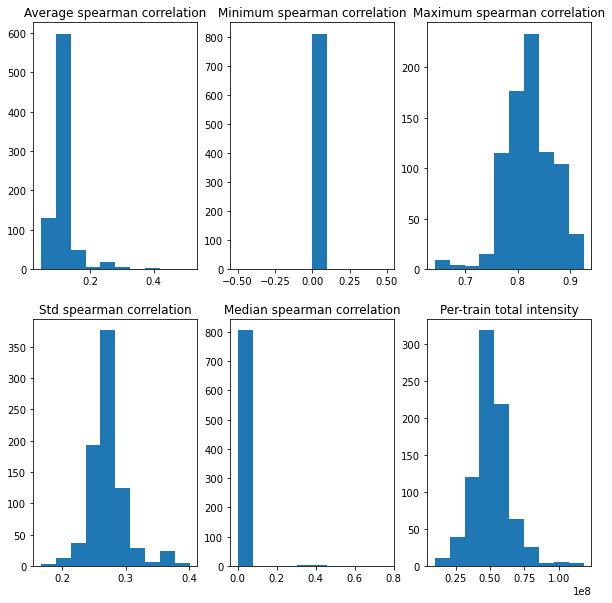

In [12]:
# Spearman correlation statistics 
fig, ax = plt.subplots(2, 3, figsize = (10,10))
ax[0,0].hist(av_spear)
ax[0,0].set_title("Average spearman correlation") 
ax[0,1].hist(min_spear) 
ax[0,1].set_title("Minimum spearman correlation") 
ax[0,2].hist(max_spear) 
ax[0,2].set_title("Maximum spearman correlation") 
ax[1,0].hist(std_spear) 
ax[1,0].set_title("Std spearman correlation")
ax[1,1].hist(med_spear) 
ax[1,1].set_title("Median spearman correlation"); 
ax[1,2].hist(per_train_tot_spear) 
ax[1,2].set_title("Per-train total intensity"); 

In [14]:
# Total per-train intensity statistics 
train_mean = np.mean(per_train_tot_pear) 
train_min = np.min(per_train_tot_pear) 
train_max = np.max(per_train_tot_pear) 
train_std = np.std(per_train_tot_pear) 
train_med = np.median(per_train_tot_pear) 

print("------------------------------------------------------")
print("Total per-train intensity statistics:")
print("------------------------------------------------------")
print("Average total intensity: %s" % (train_mean)) 
print("Minimum total intensity: %s" % (train_min)) 
print("Maximum total intensity: %s" % (train_max)) 
print("Standard deviation total intensity: %s" % (train_std)) 
print("Median total intensity: %s" % (train_med)) 
print("------------------------------------------------------")
print("------------------------------------------------------")

------------------------------------------------------
Total per-train intensity statistics:
------------------------------------------------------
Average total intensity: 51140056.668310724
Minimum total intensity: 9633041.0
Maximum total intensity: 118397736.0
Standard deviation total intensity: 13639866.697167661
Median total intensity: 50408318.0
------------------------------------------------------
------------------------------------------------------


In [ ]:
# Closing the files 
agipd_data.close() 
mask_data.close() 